In [7]:
import sys
sys.path.append('../../../')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch as tc

from BayesNewton import bayesnewton
import objax

from sklearn.linear_model import LinearRegression
from rcgp.kernels import Matern32Kernel


plt.rc('font', family='serif', size=20)
plt.rcParams['text.usetex'] = True

In [8]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02):
    tc.manual_seed(42)  # For reproducibility
    x = tc.linspace(0, 1, 100) 
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix, mean = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x)), tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)
    y = true_f + noise

    return x, y, true_f

def add_outliers(y):
    tc.manual_seed(10)

    y_outliers = y.clone().detach()
    outliers_loc = [50, 54, 57, 59, 65]
    #outliers_loc = [50, 51, 53, 54, 55, 56, 57, 59, 65]

    noise = tc.distributions.Normal(loc=0, scale=10.).sample((len(outliers_loc), ))
    y_outliers[outliers_loc] = y_outliers[outliers_loc] + noise
    return y_outliers, outliers_loc

true_lengthscale, true_magnitude, true_var_y = (0.2, 2., 0.25)
Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y)
Ys_outliers, outliers_loc = add_outliers(Ys)

In [16]:
def bayes_newton_variational(obs_grid, obs):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    lik = bayesnewton.likelihoods.StudentsT(df=3)
    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    for i in range(1, iters + 1):
        loss = train_op()

    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))

    return np.array(posterior_mean), np.sqrt(np.array(posterior_var))


In [17]:
mean_vi, std_vi = bayes_newton_variational(obs_grid=Xs.numpy().reshape(-1,1), obs=Ys.numpy().reshape(-1,1))

In [20]:
with np.load("../../issues-param-optim-stgp/stgp_fit.npz") as f:
    mean_stgp = f["pred"]
    std_stgp = f["std"]

In [4]:
comp_times=np.load('comp-times.npy', allow_pickle=True)
n_pts = comp_times[0, 0, :].reshape(-1,1)

for i, name in enumerate(['ST-RCGP', 'STGP', 'MEP', 'MVI', 'MLa']):
    print(i+1,name)
    arr = comp_times[:4, i+1, :]
    print("Total (s) : ", arr.mean(axis=0)[-1], arr.std(axis=0)[-1])

    slope = []

    for j in range(4):
        data = arr[j, :].reshape(-1,1)
        lm = LinearRegression()
        lm.fit(n_pts, data)
        slope.append(lm.coef_[0] * 1000)
    
    print("1-Step (ms) : ", np.mean(slope), np.std(slope))

1 ST-RCGP
Total (s) :  9.360330879688263 0.422743328209273
1-Step (ms) :  0.19902524999180396 0.017334830125992733
2 STGP
Total (s) :  7.976068556308746 0.7064320452566
1-Step (ms) :  0.1655211085610646 0.007677839247665911
3 MEP
Total (s) :  29.095697820186615 0.44841390174531814
1-Step (ms) :  0.595325165427548 0.013068882199379695
4 MVI
Total (s) :  28.257311165332794 0.6179961714670966
1-Step (ms) :  0.6082252574501515 0.014213357169383406
5 MLa
Total (s) :  29.201807260513306 1.9628028724482267
1-Step (ms) :  0.6155404194107187 0.030287060462741214


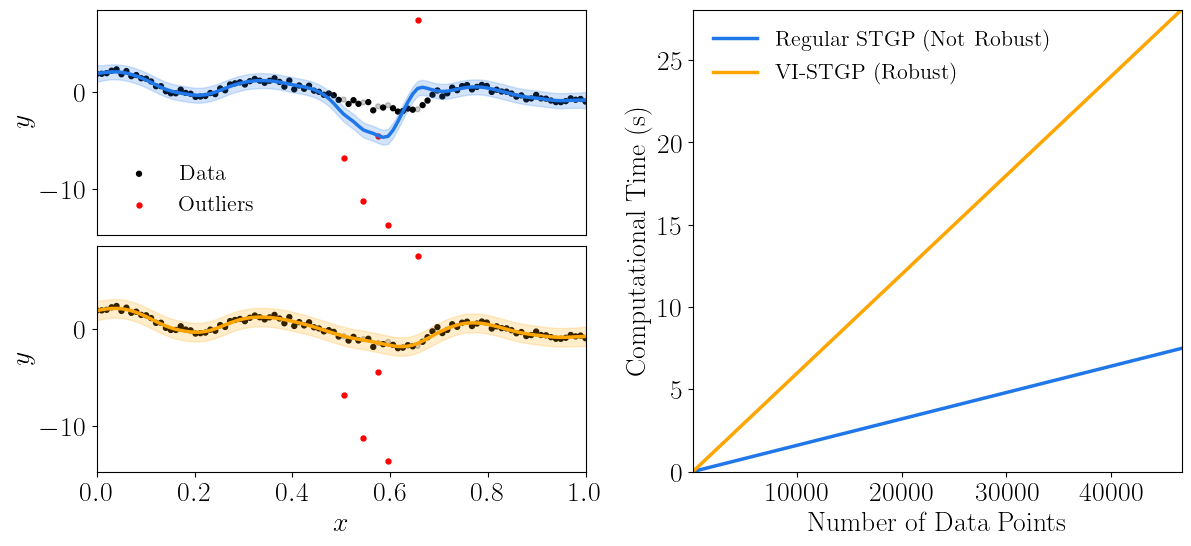

In [61]:
fig, axs = plt.subplot_mosaic(
    """
    AB
    CB
    """,
     figsize=(14, 6))

stgp_col = "#1f77e9"
vi_col = "orange"

for idx in ["A", "C"]:
    colors = ['black' if i not in outliers_loc else (0,0,0,0.2) for i in range(len(Xs))]
    axs[idx].scatter(Xs, Ys, c=colors, s=50, marker='.', label='Data')
    axs[idx].scatter(Xs[outliers_loc], Ys_outliers[outliers_loc], c='red', s=50, marker='.', label='Outliers')

axs["A"].plot(Xs, mean_stgp, color=stgp_col)
axs["A"].fill_between(Xs, mean_stgp - 3*std_stgp, mean_stgp+3*std_stgp, color=stgp_col, alpha=0.2)

axs["C"].plot(Xs, mean_vi, color=vi_col, label="VI-STGP (Robust)")
axs["C"].fill_between(Xs, mean_vi - 3*std_vi, mean_vi + 3*std_vi, color=vi_col, alpha=0.2)

axs["B"].plot(n_pts.flatten(), n_pts.flatten() * 0.16 / 1000, color=stgp_col, label="Regular STGP (Not Robust)")
axs["B"].plot(n_pts.flatten(), n_pts.flatten() * 0.6 / 1000, color=vi_col, label="VI-STGP (Robust)")

axs["B"].set_xlim(n_pts[0], n_pts[-1])
axs["B"].set_ylim(0, (n_pts.flatten() * 0.6 / 1000)[-1])

axs["B"].set_xlabel("Number of Data Points")
axs["B"].set_ylabel("Computational Time (s)")

for idx in ["A", "C"]:
    axs[idx].set_xlim(Xs[0], Xs[-1])
    axs[idx].set_ylabel(r"$y$")
    if idx=="C": axs[idx].set_xlabel(r"$x$")


axs["A"].set_xticks([])
axs["B"].legend(frameon=False, fontsize=16)
axs["A"].legend(frameon=False, fontsize=16)

fig.subplots_adjust(hspace=0.05, wspace=0.22)


#fig.savefig("./tradeoff-robust-vs-cost.pdf", format='pdf', bbox_inches='tight')

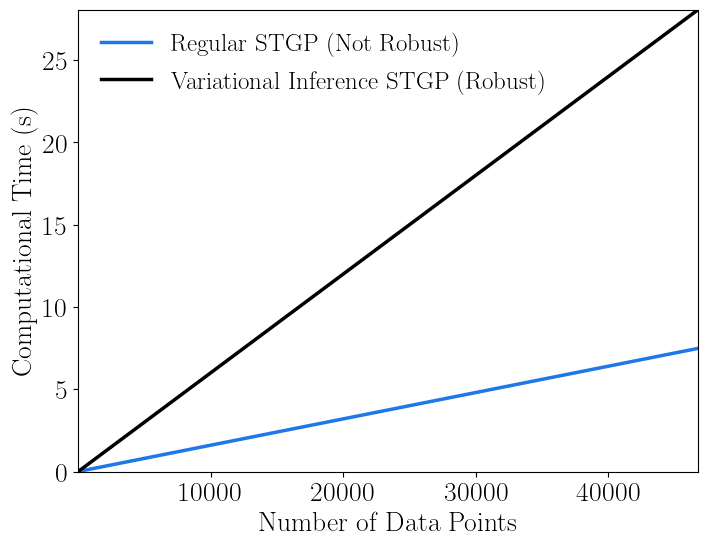

In [5]:
matplotlib.rcParams['lines.linewidth'] = 2.5

plt_arr = comp_times[1:].mean(axis=1).copy()
plt.figure(figsize=(8,6))
plt.plot(n_pts.flatten(), n_pts.flatten() * 0.16 / 1000, color="#1f77e9", label='Regular STGP (Not Robust)')
plt.plot(n_pts.flatten(), n_pts.flatten() * 0.6 / 1000, color="black", label='Variational Inference STGP (Robust)')

plt.xlim(n_pts[0], n_pts[-1])
plt.ylim(0, (n_pts.flatten() * 0.6 / 1000)[-1])

plt.ylabel("Computational Time (s)")
plt.xlabel("Number of Data Points")
plt.legend(fontsize=18, frameon=False)